# import packages

In [1]:

import json
import csv
import numpy as np
import os
import sys
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pickle
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn.functional as F
from torch.nn.functional import relu,tanh
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from livelossplot import PlotLosses
from torchsummary import summary

from tensorflow.keras.utils import plot_model




# define models

In [2]:



class ConvCaps2D(nn.Module):
    def __init__(self):
        super(ConvCaps2D, self).__init__()
        # The paper suggests having 32 8D capsules
        self.capsules = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels = primary_capslen,
                                                 kernel_size=(1,ks), stride=stride) for _ in range(filters)])

    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm) # scale.size()  is (None, 1152, 1)
        return scale*tensor / torch.sqrt(norm)

    def forward(self, x):
        outputs = [capsule(x).view(x.size(0), primary_capslen, -1) for capsule in self.capsules] # 32 list of (None, 1, 8, 36)
        outputs = torch.cat(outputs, dim = 2).permute(0, 2, 1)  # outputs.size() is (None, 1152, 8)
        return self.squash(outputs)


class Caps1D(nn.Module):
    def __init__(self):
        super(Caps1D, self).__init__()
        self.num_iterations = num_iterations
        self.num_caps = 2 # equals to class number
        self.num_routes= (int((neurons-ks)/stride)+1)*filters
        print('num_routes:{}'.format(self.num_routes))
        self.in_channels=primary_capslen
        self.out_channels=digital_capslen

        self.W = nn.Parameter(torch.randn(self.num_caps,self.num_routes, self.in_channels, self.out_channels)) # class,weight,len_capsule,capsule_layer
#         self.W = nn.Parameter(torch.randn(3, 3136, 8, 32)) # num_caps, num_routes, in_channels, out_channels
    
    
    def softmax2(self, x, axis=-1):
        ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
        return ex/K.sum(ex, axis=axis, keepdims=True)

    def softmax(self, x, dim = 1):
        transposed_input = x.transpose(dim, len(x.size()) - 1)
        softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)))
        return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(x.size()) - 1)

    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm)
        return scale*tensor / torch.sqrt(norm)

    # Routing algorithm
    def forward(self, u):
        # u.size() is (None, 1152, 8)
        '''
        From documentation
        For example, if tensor1 is a j x 1 x n x m Tensor and tensor2 is a k x m x p Tensor,
        out will be an j x k x n x p Tensor.

        We need j = None, 1, n = 1152, k = 10, m = 8, p = 16
        '''

        u_ji = torch.matmul(u[:, None, :, None, :], self.W) # u_ji.size() is (None, 10, 1152, 1, 16)

        b = Variable(torch.zeros(u_ji.size())) # b.size() is (None, 10, 1152, 1, 16)
        b = b.to(device) # using gpu

        for i in range(self.num_iterations):
            c = self.softmax(b, dim=2)
            v = self.squash((c * u_ji).sum(dim=2, keepdim=True)) # v.size() is (None, 10, 1, 1, 16)

            if i != self.num_iterations - 1:
                delta_b = (u_ji * v).sum(dim=-1, keepdim=True)
                b = b + delta_b

        # Now we simply compute the length of the vectors and take the softmax to get probability.
        v = v.squeeze()
        classes = (v ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes) # This is not done in the paper, but I've done this to use CrossEntropyLoss.
        
        #save C_ij
        c_ij=c.data.cpu().numpy()
#         print('c_ij shape:{}'.format(c_ij.shape)) #shape:(1040, 2, 2336, 1, 16)
        c_ij=c_ij[:,:,:,-1,-1] #the value in '16' dim is the same
        np.save('C_ij.npy',c_ij) #shape:(1040, 2, 2336)
        
        return classes


# for name, param in model.named_parameters():
#     if param.device.type != 'cuda:0':
#         print('param {}, not on GPU'.format(name))

class CapsNet(nn.Module):
    def __init__(self):
#         super().__init__() #py3
        super(CapsNet, self).__init__() #py2
        self.fc1 = nn.Linear(top_k,neurons)
        self.dropout1 = nn.Dropout(p=dropout)
#         self.fc2 = nn.Linear(256,64)
#         self.out_channel=16
#         self.conv1 = nn.Conv2d(in_channels = 1, out_channels = self.out_channel, kernel_size = (1,3), stride = 1)
#         self.conv1_bn = nn.BatchNorm2d(self.out_channel)

#         self.conv2 = nn.Conv2d(in_channels = self.out_channel, out_channels = 2*self.out_channel, kernel_size = (3,3), stride = 2)
#         self.conv2_bn = nn.BatchNorm2d(2*self.out_channel)

#         self.conv3 = nn.Conv2d(in_channels = 2*self.out_channel, out_channels = 2*2*self.out_channel, kernel_size = (3,3), stride = 1)
#         self.conv3_bn = nn.BatchNorm2d(2*2*self.out_channel)

        self.primaryCaps = ConvCaps2D()
        self.digitCaps = Caps1D()


    def forward(self, x):
        x = act(self.dropout1(self.fc1(x)))
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.conv1_bn(self.conv1(x)))
#         x = F.relu(self.conv2_bn(self.conv2(x)))
#         x = F.relu(self.conv3_bn(self.conv3(x)))
        x = self.primaryCaps(x)
        x = self.digitCaps(x)

        return x



In [3]:
top_k=75584

#use the best param, id:89
neurons=150
dropout=0.5
primary_capslen=4
digital_capslen=16
ks=5
stride=2
filters=32
num_iterations=3 #danymic routing iterations

##
initial_lr=0.0001
batch_size=128
epochs=30
act=relu

In [4]:
(int((neurons-ks)/stride)+1)
73*32
29*32
36*32

73

2336

928

1152

In [5]:
device = torch.device('cuda:0')
model = CapsNet()
model.load_state_dict(torch.load("./capsule_pca.best_model.pt")) #recommended officically
model.eval()
model.to(device);
# model.fc1.weight.data

num_routes:2336


In [6]:

# read once a time
dataset_X,_=pickle.load(open('sigSNPs_pca.features.pkl','rb'))
print(dataset_X.shape)

dataset_X=np.array(dataset_X) # extract selected features

_,dataset_Y=pickle.load(open('../chr1/genes/A3GALT2.pkl','rb'))

dataset_X.shape
dataset_Y.shape




(10405, 75584)


(10405, 75584)

(10405, 2)

In [7]:

# # train dataset
# train_idx = [int(line.strip()) for line in open("../train_val.unique.idx", 'r')]
# x_train=dataset_X[train_idx]

# # test dataset
# te_idx = [int(line.strip()) for line in open("../test.idx", 'r')]
# x_test=dataset_X[te_idx]
# x_train.shape
# x_test.shape


# x_train=x_train.reshape(x_train.shape[0],1,1,x_train.shape[1])

# x_test=x_test.reshape(x_test.shape[0],1,1,x_test.shape[1])

# y_train =dataset_Y[train_idx]

# y_train = np.argmax(y_train, axis=1)

# y_test =dataset_Y[te_idx]

# y_test = np.argmax(y_test, axis=1)


In [8]:
# in_train=Variable(torch.tensor(x_train[:500]).to(device))
# y_pred = model(in_train).detach().cpu().numpy()
# y_pred = np.argmax(y_pred, axis=1)
# y_true = y_train[:500]

# Compute C_ij for training data (need to split dataset then merge)

In [9]:
def compute_average_cij_for_testdata(x_test,y_test):
    in_test=Variable(torch.tensor(x_test).to(device))
    y_pred = model(in_test).detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    y_true = y_test
    
    c=np.load('C_ij.npy')
    c=c.reshape(c.shape[0],c.shape[1],32,73)
    c=np.sum(c,axis=-1)

    num_classes=2
    phenotype = ['Healthy','ALS']
    pheno2coefficients={}
    count = {}
    for i in range(len(c)):
        ind = int(y_test[i])     #phenotype
        if ind in pheno2coefficients.keys():
            pheno2coefficients[ind] = pheno2coefficients[ind] + c[i]   #sum of coupling coefficients for each phenotype
            count[ind] = count[ind] + 1   #sample counts for each type   
        else:
            pheno2coefficients[ind] = c[i]
            count[ind] = 1

    total = np.zeros((c.shape[1],c.shape[-1]))

    #type average coupling coefficients
    for i in range(num_classes):
        average = pheno2coefficients[i]/count[i]   #sum/count = average
        total[i] = average[i]
#     print(total)
    Cij=total
    return Cij


In [10]:
def compute_average_cij_for_traindata(x_train,y_train):
    k=int(x_train.shape[0]/1000)+1
    y_pred=np.array([])
    for i in range(k):
        upper = min(x_train.shape[0],(i+1)*1000)
    #     print(i,upper)
        in_train=Variable(torch.tensor(x_train[(i*1000):upper]).to(device))
        y_pred0 = model(in_train).detach().cpu().numpy()
        y_pred0 = np.argmax(y_pred0, axis=1)
        y_pred = np.concatenate([y_pred,y_pred0])
        o=os.system('mv C_ij.npy C_ij.{}.npy'.format(i))
    y_true = y_train
    y_pred.shape
    #merge all Cij
    c=np.array([])
    for i in range(k):
        c0=np.load('C_ij.{}.npy'.format(i))
        if i==0:
            c=c0
        else:
            c=np.vstack([c,c0])
     
    c=c.reshape(c.shape[0],c.shape[1],32,73)
    c=np.sum(c,axis=-1)

    num_classes=2
    phenotype = ['Healthy','ALS']
    pheno2coefficients={}
    count = {}
    for i in range(len(c)):
        ind = int(y_train[i])     #phenotype
        if ind in pheno2coefficients.keys():
            pheno2coefficients[ind] = pheno2coefficients[ind] + c[i]   #sum of coupling coefficients for each phenotype
            count[ind] = count[ind] + 1   #sample counts for each type   
        else:
            pheno2coefficients[ind] = c[i]
            count[ind] = 1

    total = np.zeros((c.shape[1],c.shape[-1]))

    #type average coupling coefficients
    for i in range(num_classes):
        average = pheno2coefficients[i]/count[i]   #sum/count = average
        total[i] = average[i]
    Cij=total
    Cij.shape
    return Cij


In [11]:
gene2Cij_train_list=[]
for i in range(1,5):
    t=pickle.load(open('{}/Cij_for_single_gene.{}.pkl'.format(i,i),'rb')) #based on training data
    gene2Cij_train_list.extend(t)
len(gene2Cij_train_list)

18265

In [12]:
genes=[]
Cij_train_tensor=[]
for item in gene2Cij_train_list:
    gene,Cij_train=item
    genes.append(gene)
    Cij_train_tensor.append(Cij_train)
#     print(gene,Cij_train.shape)
Cij_train_tensor=np.array(Cij_train_tensor)
Cij_train_tensor.shape

(18265, 2, 32)

In [13]:
len(genes)

18265

<Figure size 324x216 with 0 Axes>

18265

Text(0.5, 0, 'Coupling coefficient')

Text(0, 0.5, 'Density')

369

922

183

6846

922

503345

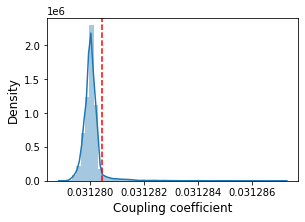

In [14]:
#for primary capsule i
plt.figure(figsize=[4.5,3]) #width around 180mm := 7 inches

pc=5
# pc=28
# pc=4
# pc=17
# v=Cij_train_tensor[:,0,pc-1]
v=Cij_train_tensor[:,1,pc-1]
len(v)
# gene2pc5cij={genes[k]:v_ for k,v_ in enumerate(v)}
sns.distplot(v)
plt.axvline(x=np.quantile(v,0.95),color='red', linestyle='dashed')
# plt.axvline(x=np.quantile(v,0.98),color='green', linestyle='dashed')
# plt.axvline(x=np.quantile(v,0.99),color='yellow', linestyle='dashed')
plt.xlabel('Coupling coefficient',fontsize=12)
plt.ylabel('Density',fontsize=12)
sum(v>=np.quantile(v,0.98))
sum(v>=np.quantile(v,0.95))
sum(v>=np.quantile(v,0.99))

target_genes={genes[k]:1 for k,v_ in enumerate(v) if v_>=np.quantile(v,0.95)}
# target_genes={genes[k]:1 for k,v_ in enumerate(v) if v_>=np.quantile(v,0.99)}
# target_genes={genes[k]:1 for k,v_ in enumerate(v) if v_>=np.quantile(v,0.98)}

with open('target_genes.95th_percentile.pc{}'.format(pc),'w') as fw:
    fw.write('\n'.join(list(target_genes.keys())))
len(target_genes)

with open('sorted_genes2cij.95th_percentile.pc{}'.format(pc),'w') as fw:
    g2cij_={genes[k]:v_ for k,v_ in enumerate(v)}
    fw.write('\n'.join(['{}\t{}'.format(a,b) for a,b in sorted(g2cij_.items(),key=lambda d:d[1],reverse=True)]))
    
plt.savefig('target_genes.95th_percentile.pc5.dist.pdf',bbox_inches='tight') #bbox_inches='tight' ,keep all elements in fig
# plt.show()

In [15]:
target_genes_pc5={line.strip():1 for line in open("target_genes.95th_percentile.pc5", 'r')}
# target_genes_pc4={line.strip():1 for line in open("target_genes.pc4", 'r')}
# target_genes_pc28={line.strip():1 for line in open("target_genes.pc28", 'r')}

# target_genes={g:1 for g in target_genes_pc5 if (g not in target_genes_pc28 and g not in target_genes_pc4)}
len(target_genes)

922

# plot coefficient using all genes on training / test data

In [16]:


# train dataset
train_idx = [int(line.strip()) for line in open("../train_val.unique.idx", 'r')]
x_train=dataset_X[train_idx]

# test dataset
te_idx = [int(line.strip()) for line in open("../test.idx", 'r')]
x_test=dataset_X[te_idx]
x_train.shape
x_test.shape


x_train=x_train.reshape(x_train.shape[0],1,1,x_train.shape[1])

x_test=x_test.reshape(x_test.shape[0],1,1,x_test.shape[1])

y_train =dataset_Y[train_idx]

y_train = np.argmax(y_train, axis=1)

y_test =dataset_Y[te_idx]

y_test = np.argmax(y_test, axis=1)


in_test=Variable(torch.tensor(x_train[:1000]).to(device))
# in_test=Variable(torch.tensor(x_test).to(device))
y_pred = model(in_test).detach().cpu().numpy()

y_pred = np.argmax(y_pred, axis=1)
y_true = y_train[:1000]

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
acc = round((tp + tn) * 1. / (tp + fp + tn + fn),3)
precision = round(tp*1./(tp+fp),3)
recall = round(tp*1./(tp+fn),3)
f1=round(2*(precision*recall)/(precision+recall),3)

print('\t'.join(list(map(str,[precision,recall,f1,acc])))+'\n')

(9365, 75584)

(1040, 75584)

/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.837	0.98	0.903	0.938



/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


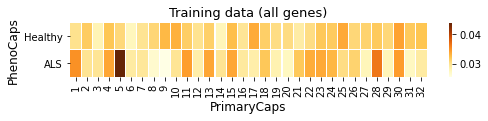

In [17]:
cmap='YlOrBr'
phenotype = ['Healthy','ALS']
c=compute_average_cij_for_traindata(x_train,y_train)
c.shape
fs=12

#overall heatmap
plt.figure(figsize=[8,1]) #width around 180mm := 7 inches
df = pd.DataFrame(np.asmatrix(c),index=phenotype,columns=list(range(1,c.shape[-1]+1)))
vmax=np.max(np.asmatrix(df))
vmin=np.min(np.asmatrix(df))

# ax = sns.heatmap(df,linewidths=.1,cmap=cmap,vmax=vmax,vmin=vmin)
ax = sns.heatmap(df,linewidths=.1,cmap=cmap)
plt.title('Training data (all genes)',fontsize=fs+1) #Overall(health+ALS)
plt.ylabel('PhenoCaps', fontsize=fs)
plt.xlabel('PrimaryCaps', fontsize=fs)

# plt.savefig('capsule_train.all_genes.cc_heatmap.png',dpi=400,bbox_inches='tight') 
plt.savefig('capsule_train.all_genes.cc_heatmap.pdf',bbox_inches='tight') 
plt.show()
print();

/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


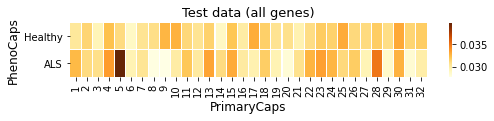

In [18]:
cmap='YlOrBr'
phenotype = ['Healthy','ALS']
c=compute_average_cij_for_testdata(x_test,y_test)
c.shape
fs=12

#overall heatmap
plt.figure(figsize=(8,1))
df = pd.DataFrame(np.asmatrix(c),index=phenotype,columns=list(range(1,c.shape[-1]+1)))
ax = sns.heatmap(df,linewidths=.1,cmap=cmap)
plt.title('Test data (all genes)',fontsize=fs+1)
plt.ylabel('PhenoCaps', fontsize=fs)
plt.xlabel('PrimaryCaps', fontsize=fs)
# plt.savefig('capsule_test.all_genes.cc_heatmap.png',dpi=400,bbox_inches='tight') 
plt.savefig('capsule_test.all_genes.cc_heatmap.pdf',bbox_inches='tight') 
plt.show()

print();

In [19]:
df

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
Healthy,0.030356,0.031428,0.029331,0.032291,0.031100,0.028887,0.030621,0.030947,0.032754,0.032889,...,0.031855,0.031554,0.033113,0.031218,0.031125,0.031788,0.030978,0.033207,0.031383,0.031808
ALS,0.032612,0.031113,0.030891,0.033669,0.039888,0.029470,0.030583,0.027838,0.027652,0.030038,...,0.033515,0.032731,0.031231,0.031765,0.029374,0.035055,0.028747,0.032871,0.028404,0.029943


In [20]:
pd.DataFrame.max(df,axis=1)

Healthy    0.033207
ALS        0.039888
dtype: float64

/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


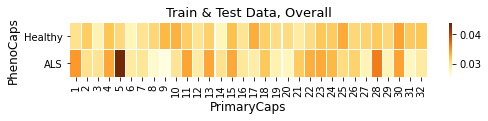

In [21]:
cmap='YlOrBr'
phenotype = ['Healthy','ALS']
#For both train and test data
c=compute_average_cij_for_traindata(np.concatenate([x_train,x_test]),np.concatenate([y_train,y_test])) 
c.shape
fs=12

#overall heatmap
plt.figure(figsize=(8,1))
df = pd.DataFrame(np.asmatrix(c),index=phenotype,columns=list(range(1,c.shape[-1]+1)))
ax = sns.heatmap(df,linewidths=.1,cmap=cmap,vmax=vmax,vmin=vmin)
plt.title('Train & Test Data, Overall',fontsize=fs+1)
plt.ylabel('PhenoCaps', fontsize=fs)
plt.xlabel('PrimaryCaps', fontsize=fs)
plt.show()

print();

# only feed target genes into capsule network

In [22]:
X,Y=pickle.load(open('sigSNPs_pca.features.pkl','rb'))
print(X.shape)
print(Y.shape)
X2=np.array(copy.deepcopy(X))

(10405, 75584)
(10405,)


In [23]:
# test dataset
te_idx = [int(line.strip()) for line in open("../test.idx", 'r')]


In [24]:
len(target_genes)

922

In [25]:

x_test=X.iloc[te_idx]
x_test=np.array(x_test)

x_test.shape

for i in range(X.shape[1]):
    if X.columns[i].split(':')[1] not in target_genes: #there are some duplicated genes located on different chrs
#         x_test.iloc[:,i]=0. #replace in dataframe is very slow
        x_test[:,i]=0.
        X2[:,i]=0.
        

(1040, 75584)

In [26]:
x_test=x_test.reshape(x_test.shape[0],1,1,x_test.shape[1])

in_test=Variable(torch.tensor(x_test).to(device))
y_pred = model(in_test).detach().cpu().numpy()

y_pred = np.argmax(y_pred, axis=1)
y_true = y_test


tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
acc = round((tp + tn) * 1. / (tp + fp + tn + fn),3)
precision = round(tp*1./(tp+fp),3)
recall = round(tp*1./(tp+fn),3)
f1=round(2*(precision*recall)/(precision+recall),3)

print('\t'.join(list(map(str,[precision,recall,f1,acc])))+'\n')

/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.763	0.754	0.758	0.76



In [27]:
#quantile98: 0.719	0.675	0.696	0.706
#quantile95: 0.763	0.754	0.758	0.760
#quantile99: 0.657	0.585	0.619	0.639


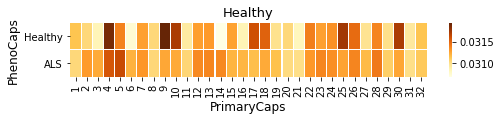

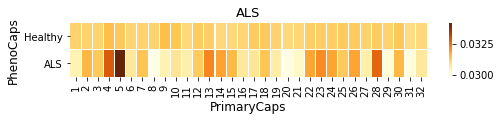

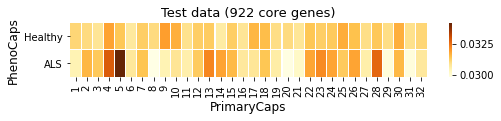

only use target genes, test data


In [28]:
c=np.load('C_ij.npy')
c=c.reshape(c.shape[0],c.shape[1],32,73)
c=np.sum(c,axis=-1)
c.shape

num_classes=2
phenotype = ['Healthy','ALS']
pheno2coefficients={}
count = {}
for i in range(len(c)):
    ind = int(y_test[i])     #phenotype
    if ind in pheno2coefficients.keys():
        pheno2coefficients[ind] = pheno2coefficients[ind] + c[i]   #sum of coupling coefficients for each phenotype
        count[ind] = count[ind] + 1   #sample counts for each type   
    else:
        pheno2coefficients[ind] = c[i]
        count[ind] = 1

total = np.zeros((c.shape[1],c.shape[-1]))

#type average coupling coefficients
fs=12
for i in range(num_classes):
    average = pheno2coefficients[i]/count[i]   #sum/count = average
    k = i + 1
    plt.figure(figsize=(8,1))
    plt.title(phenotype[i],fontsize=fs+1)
    total[i] = average[i]
    df = pd.DataFrame(np.asmatrix(average),columns=list(range(1,c.shape[-1]+1)))
    heatmap = sns.heatmap(df,yticklabels=phenotype,linewidths=.1,cmap=cmap)
    plt.ylabel('PhenoCaps', fontsize=fs)
    plt.xlabel('PrimaryCaps', fontsize=fs)
plt.show()

#overall heatmap
plt.figure(figsize=(8,1))
df = pd.DataFrame(np.asmatrix(total),index=phenotype,columns=list(range(1,c.shape[-1]+1)))
ax = sns.heatmap(df,linewidths=.1,cmap=cmap)
plt.title('Test data (922 core genes)',fontsize=fs+1)#for both healthy and ALS
plt.ylabel('PhenoCaps', fontsize=fs)
plt.xlabel('PrimaryCaps', fontsize=fs)
plt.savefig('capsule_test.core_genes.cc_heatmap.pdf',bbox_inches='tight') 
plt.show()

print("only use target genes, test data");

In [29]:
df

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
Healthy,0.031149,0.031053,0.030854,0.031882,0.031400,0.030752,0.031282,0.031053,0.031942,0.031726,...,0.031282,0.031346,0.031755,0.031490,0.030995,0.031387,0.031014,0.031729,0.030954,0.031149
ALS,0.030480,0.031622,0.031367,0.032851,0.034181,0.030791,0.031451,0.029827,0.030476,0.030861,...,0.032180,0.031854,0.031351,0.031861,0.030603,0.032674,0.029987,0.031605,0.029948,0.030767


In [30]:
pd.DataFrame.max(df,axis=1)

Healthy    0.031942
ALS        0.034181
dtype: float64

In [31]:
1/32

0.03125

/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


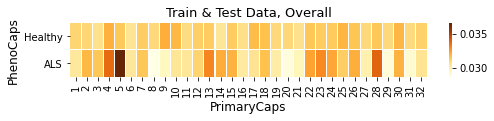

In [32]:
X2=X2.reshape(X2.shape[0],1,1,X2.shape[1])
X2.shape

cmap='YlOrBr'
phenotype = ['Healthy','ALS']
#For both train and test data
c=compute_average_cij_for_traindata(X2,Y) 
c.shape
fs=12

#overall heatmap
plt.figure(figsize=(8,1))
df = pd.DataFrame(np.asmatrix(c),index=phenotype,columns=list(range(1,c.shape[-1]+1)))
ax = sns.heatmap(df,linewidths=.1,cmap=cmap)
plt.title('Train & Test Data, Overall',fontsize=fs+1)
plt.ylabel('PhenoCaps', fontsize=fs)
plt.xlabel('PrimaryCaps', fontsize=fs)
plt.show()

print();

/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


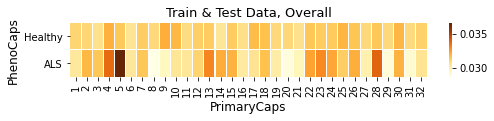

In [33]:
cmap='YlOrBr'
phenotype = ['Healthy','ALS']
#For both train and test data
c=compute_average_cij_for_traindata(X2,Y) 
c.shape
fs=12

#overall heatmap
plt.figure(figsize=(8,1))
df = pd.DataFrame(np.asmatrix(c),index=phenotype,columns=list(range(1,c.shape[-1]+1)))
ax = sns.heatmap(df,linewidths=.1,cmap=cmap)
plt.title('Train & Test Data, Overall',fontsize=fs+1)
plt.ylabel('PhenoCaps', fontsize=fs)
plt.xlabel('PrimaryCaps', fontsize=fs)
plt.show()

print();

--- 

# only feed randomly chosen k genes into capsule network

In [35]:
res_rand_kgenes=[]
# num_genes=[50,69,100,118,300,500] #69,118 for acc>0.5 recall>0 genes
# num_genes=[69,118] #69,118 for acc>0.5 recall>0 genes
num_genes=[922] #95th percentile
for k in num_genes:
    # k=100 #number of randomly chosen genes
    for _ in range(1000):
        target_genes={}
        all_input_genes=[]
        with open('all_input.genes') as fr:
            for line in fr:
                all_input_genes.append(line.strip())

        random.shuffle(all_input_genes)
        target_genes={gene:1 for gene in random.sample(all_input_genes,k)}
        # len(target_genes)

        # test dataset
        te_idx = [int(line.strip()) for line in open("../test.idx", 'r')]

        x_test=X.iloc[te_idx]
        x_test=np.array(x_test)

        for i in range(X.shape[1]):
            if X.columns[i].split(':')[1] not in target_genes: #there are some duplicated genes located on different chrs
        #         x_test.iloc[:,i]=0. #replace in dataframe is very slow
                x_test[:,i]=0.

        x_test=x_test.reshape(x_test.shape[0],1,1,x_test.shape[1])

        in_test=Variable(torch.tensor(x_test).to(device))
        y_pred = model(in_test).detach().cpu().numpy()

        y_pred = np.argmax(y_pred, axis=1)
        y_true = y_test


        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        acc = round((tp + tn) * 1. / (tp + fp + tn + fn),3)
        precision = round(tp*1./(tp+fp),3)
        recall = round(tp*1./(tp+fn),3)
        f1=round(2*(precision*recall)/(precision+recall),3)

    #     print('\t'.join(list(map(str,[precision,recall,f1,acc])))+'\n')
        res_rand_kgenes.append([k,precision,recall,f1,acc])

In [ ]:
res_rand_kgenes=pd.DataFrame(res_rand_kgenes,columns=['numOfGenes','precision','recall','f1','accuracy'])
res_rand_kgenes[:4]

In [ ]:
res_rand_kgenes.to_csv("random_core_genes.test_result.csv",index=False)

In [36]:
res_rand_kgenes=pd.read_csv("random_core_genes.test_result.csv")
res_rand_kgenes[:3]

,numOfGenes,precision,recall,f1,accuracy
0,922,0.730,0.583,0.648,0.684
1,922,0.733,0.592,0.655,0.688
2,922,0.726,0.600,0.657,0.687


<Figure size 324x216 with 0 Axes>

Text(0.5, 0, 'Test accuracy (random genes)')

Text(0, 0.5, 'Density')

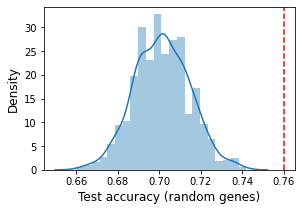

In [38]:
plt.figure(figsize=[4.5,3]) #width around 180mm := 7 inches
sns.distplot(res_rand_kgenes['accuracy'])
plt.axvline(x=0.76,color='red', linestyle='dashed')
plt.xlabel('Test accuracy (random genes)',fontsize=12)
plt.ylabel('Density',fontsize=12)

plt.savefig('random_genes.accuray_dist.pdf',bbox_inches='tight') #bbox_inches='tight' ,keep all elements in fig
plt.show()

In [39]:
res_rand_kgenes.groupby('numOfGenes').mean()
res_rand_kgenes.groupby('numOfGenes').max()

,precision,recall,f1,accuracy
numOfGenes,,,,
922,0.74598,0.610882,0.671533,0.701339


,precision,recall,f1,accuracy
numOfGenes,,,,
922,0.809,0.669,0.717,0.742


In [40]:
res_rand_kgenes.groupby('numOfGenes').mean()
res_rand_kgenes.groupby('numOfGenes').std()


,precision,recall,f1,accuracy
numOfGenes,,,,
922,0.74598,0.610882,0.671533,0.701339


,precision,recall,f1,accuracy
numOfGenes,,,,
922,0.016848,0.020508,0.016396,0.013449


# only feed randomly genes(same number with core genes) into capsule network

In [45]:
res_from_rand_genes=[]
for _ in range(1):
    target_genes={}
    all_input_genes=[]
    with open('all_input.genes') as fr:
        for line in fr:
            all_input_genes.append(line.strip())

    random.shuffle(all_input_genes)
    target_genes={gene:1 for gene in random.sample(all_input_genes,922)} ## change the number of genes
#     len(target_genes)

    # test dataset
    te_idx = [int(line.strip()) for line in open("../test.idx", 'r')]
#     X.columns


    x_test=X.iloc[te_idx]
    x_test=np.array(x_test)

#     x_test.shape

    for i in range(X.shape[1]):
        if X.columns[i].split(':')[1] not in target_genes: #there are some duplicated genes located on different chrs
    #         x_test.iloc[:,i]=0. #replace in dataframe is very slow
            x_test[:,i]=0.


    x_test=x_test.reshape(x_test.shape[0],1,1,x_test.shape[1])

    in_test=Variable(torch.tensor(x_test).to(device))
    y_pred = model(in_test).detach().cpu().numpy()

    y_pred = np.argmax(y_pred, axis=1)
    y_true = y_test


    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = round((tp + tn) * 1. / (tp + fp + tn + fn),3)
    precision = round(tp*1./(tp+fp),3)
    recall = round(tp*1./(tp+fn),3)
    f1=round(2*(precision*recall)/(precision+recall),3)

    res_from_rand_genes.append([precision,recall,f1,acc])

/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/export/scratch1/home/vincent/software/miniconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


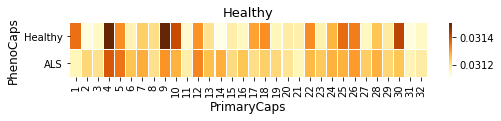

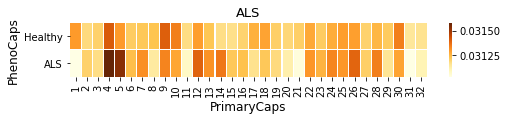

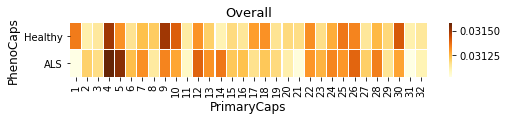

In [46]:
c=np.load('C_ij.npy')
c=c.reshape(c.shape[0],c.shape[1],32,73)
c=np.sum(c,axis=-1)
c.shape

num_classes=2
phenotype = ['Healthy','ALS']
pheno2coefficients={}
count = {}
for i in range(len(c)):
    ind = int(y_test[i])     #phenotype
    if ind in pheno2coefficients.keys():
        pheno2coefficients[ind] = pheno2coefficients[ind] + c[i]   #sum of coupling coefficients for each phenotype
        count[ind] = count[ind] + 1   #sample counts for each type   
    else:
        pheno2coefficients[ind] = c[i]
        count[ind] = 1

total = np.zeros((c.shape[1],c.shape[-1]))

#type average coupling coefficients
fs=12
for i in range(num_classes):
    average = pheno2coefficients[i]/count[i]   #sum/count = average
    k = i + 1
    plt.figure(figsize=(8,1))
    plt.title(phenotype[i],fontsize=fs+1)
    total[i] = average[i]
    df = pd.DataFrame(np.asmatrix(average),columns=list(range(1,c.shape[-1]+1)))
    heatmap = sns.heatmap(df,yticklabels=phenotype,linewidths=.1,cmap=cmap)
    plt.ylabel('PhenoCaps', fontsize=fs)
    plt.xlabel('PrimaryCaps', fontsize=fs)
plt.show()

#overall heatmap
plt.figure(figsize=(8,1))
df = pd.DataFrame(np.asmatrix(total),index=phenotype,columns=list(range(1,c.shape[-1]+1)))
ax = sns.heatmap(df,linewidths=.1,cmap=cmap)
plt.title('Overall',fontsize=fs+1)
plt.ylabel('PhenoCaps', fontsize=fs)
plt.xlabel('PrimaryCaps', fontsize=fs)
plt.show()

print();

In [44]:

# #save png for overall heatmap, limit legend
# fig=plt.figure(figsize=(8,1.2))
# df = pd.DataFrame(np.asmatrix(total),index=phenotype,columns=list(range(1,c.shape[-1]+1)))
# ax=sns.heatmap(df,linewidths=.1,cmap=cmap,vmin=vmin,vmax=vmax)
# # plt.title('Overall',fontsize=fs+1)
# plt.ylabel('PhenoCaps', fontsize=fs)
# plt.xlabel('PrimaryCaps', fontsize=fs)
# # plt.tight_layout()
# plt.savefig('capsule_rand_genes_heatmap.png',dpi=400,bbox_inches='tight') #bbox_inches='tight' ,keep all elements in fig
# plt.show()
# do not use the same scale for the legend of heatmaps, otherwise it is bad to show